# Demo: Evaluation on ClinicalNotes v0

Access data here: https://huggingface.co/datasets/jmaasch/compositional_causal_reasoning

This demo provides a walk-through of:
1. How to use the ClinicalNotes datasets for CCR evaluation.
   - Standard metrics: F1, accuracy, precision, recall.
   - Metrics for counterfactual reasoning evaluation: external validity RAE and internal consistency RAE.
2. How to generate new random ClinicalNotes tasks.

For more information on the counterfactual reasoning metrics, see [Maasch et al. 2025 (ICML)](https://arxiv.org/abs/2503.04556).

Code by Jacqueline Maasch | April 2025

In [1]:
# General importations.
import pandas as pd
import numpy as np
import os
import sys
from ast import literal_eval
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import Utils
from clinical_notes import ClinicalNotes

In [2]:
u = Utils()

In [3]:
path = "../static_datasets/clinical_notes_v0/"

## Import static datasets

In [4]:
# Load raw data.
df = pd.read_csv(path+"clinical_notes_v0.csv")
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 19 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Task ID                                 120000 non-null  float64
 1   Context ID                              120000 non-null  int64  
 2   Sample ID                               120000 non-null  int64  
 3   Replicate ID                            120000 non-null  int64  
 4   Nodes per BCC                           120000 non-null  object 
 5   DAG adjacency matrix                    120000 non-null  object 
 6   DAG nodes                               120000 non-null  object 
 7   CCT adjacency matrix                    120000 non-null  object 
 8   CCT nodes                               120000 non-null  object 
 9   Exogenous variables                     120000 non-null  object 
 10  Bernoulli parameters                    1200

,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,DAG adjacency matrix,DAG nodes,CCT adjacency matrix,CCT nodes,Exogenous variables,Bernoulli parameters,Global quantity,Local quantities,Compositions,Causal context,Sample context,Factual queries,Counterfactual queries (cause = True),Counterfactual queries (cause = False)
0,0.0,0,0,0,"[3, 3]",[[0 1 1 0 0]\n [0 0 1 0 0]\n [0 0 0 1 1]\n [0 ...,"['pain', 'A2B4', 'MY0L', '2H6V', 'surgery']",[[0 1 1]\n [0 0 1]\n [0 0 0]],"['pain', 'MY0L', 'surgery']","['5IZI', 'VSYH', 'PQUP', 'E1N9', 'AA5P']","[0.5, 0.5, 0.5, 0.5, 0.5]","('pain', 'surgery')","[('pain', 'MY0L'), ('MY0L', 'surgery')]","[[('pain', 'MY0L'), ('MY0L', 'surgery')]]",Chronic disease Z4PQJD sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
1,0.0,0,0,1,"[3, 3]",[[0 1 1 0 0]\n [0 0 1 0 0]\n [0 0 0 1 1]\n [0 ...,"['pain', 'A2B4', 'MY0L', '2H6V', 'surgery']",[[0 1 1]\n [0 0 1]\n [0 0 0]],"['pain', 'MY0L', 'surgery']","['5IZI', 'VSYH', 'PQUP', 'E1N9', 'AA5P']","[0.5, 0.5, 0.5, 0.5, 0.5]","('pain', 'surgery')","[('pain', 'MY0L'), ('MY0L', 'surgery')]","[[('pain', 'MY0L'), ('MY0L', 'surgery')]]",Chronic disease Z4PQJD sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
2,0.0,0,0,2,"[3, 3]",[[0 1 1 0 0]\n [0 0 1 0 0]\n [0 0 0 1 1]\n [0 ...,"['pain', 'A2B4', 'MY0L', '2H6V', 'surgery']",[[0 1 1]\n [0 0 1]\n [0 0 0]],"['pain', 'MY0L', 'surgery']","['5IZI', 'VSYH', 'PQUP', 'E1N9', 'AA5P']","[0.5, 0.5, 0.5, 0.5, 0.5]","('pain', 'surgery')","[('pain', 'MY0L'), ('MY0L', 'surgery')]","[[('pain', 'MY0L'), ('MY0L', 'surgery')]]",Chronic disease Z4PQJD sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
3,0.0,0,0,3,"[3, 3]",[[0 1 1 0 0]\n [0 0 1 0 0]\n [0 0 0 1 1]\n [0 ...,"['pain', 'A2B4', 'MY0L', '2H6V', 'surgery']",[[0 1 1]\n [0 0 1]\n [0 0 0]],"['pain', 'MY0L', 'surgery']","['5IZI', 'VSYH', 'PQUP', 'E1N9', 'AA5P']","[0.5, 0.5, 0.5, 0.5, 0.5]","('pain', 'surgery')","[('pain', 'MY0L'), ('MY0L', 'surgery')]","[[('pain', 'MY0L'), ('MY0L', 'surgery')]]",Chronic disease Z4PQJD sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
4,0.0,0,0,4,"[3, 3]",[[0 1 1 0 0]\n [0 0 1 0 0]\n [0 0 0 1 1]\n [0 ...,"['pain', 'A2B4', 'MY0L', '2H6V', 'surgery']",[[0 1 1]\n [0 0 1]\n [0 0 0]],"['pain', 'MY0L', 'surgery']","['5IZI', 'VSYH', 'PQUP', 'E1N9', 'AA5P']","[0.5, 0.5, 0.5, 0.5, 0.5]","('pain', 'surgery')","[('pain', 'MY0L'), ('MY0L', 'surgery')]","[[('pain', 'MY0L'), ('MY0L', 'surgery')]]",Chronic disease Z4PQJD sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."


In [5]:
# Convert adjacency matrices back to numpy arrays.
def string_to_array(array_string):
    cleaned_string = array_string.replace('\n', '')
    cleaned_string = cleaned_string.replace(' ', ', ')
    new_list = literal_eval(cleaned_string)
    return np.array(new_list)

print(string_to_array(df["DAG adjacency matrix"][0]))

df["DAG adjacency matrix"] = df["DAG adjacency matrix"].apply(string_to_array)

[[0 1 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 1]
 [0 0 0 0 1]
 [0 0 0 0 0]]


In [6]:
# Total observations per Context ID.
df["Context ID"].value_counts()

Context ID
0     10000
1     10000
2     10000
3     10000
4     10000
5     10000
6     10000
7     10000
8     10000
9     10000
10    10000
11    10000
Name: count, dtype: int64

In [7]:
# Total observations per graph size.
df["Nodes per BCC"].value_counts()

Nodes per BCC
[3, 3]       30000
[3, 3, 3]    30000
[4, 4]       30000
[4, 4, 4]    30000
Name: count, dtype: int64

In [8]:
# Load factual prompts.
df_f = pd.read_csv(path+"clinical_notes_factual_v0.csv")
print(df_f.info())
display(df_f.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Task ID        300000 non-null  float64
 1   Context ID     300000 non-null  int64  
 2   Sample ID      300000 non-null  int64  
 3   Replicate ID   300000 non-null  int64  
 4   Nodes per BCC  300000 non-null  object 
 5   Effect         300000 non-null  object 
 6   Prompt         300000 non-null  object 
 7   True           300000 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 18.3+ MB
None


,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,Effect,Prompt,True
0,0.0,0,0,0,"[3, 3]",surgery,Chronic disease Z4PQJD sometimes requires surg...,1
1,0.0,0,0,0,"[3, 3]",MY0L,Chronic disease Z4PQJD sometimes requires surg...,1
2,0.0,0,0,1,"[3, 3]",surgery,Chronic disease Z4PQJD sometimes requires surg...,1
3,0.0,0,0,1,"[3, 3]",MY0L,Chronic disease Z4PQJD sometimes requires surg...,1
4,0.0,0,0,2,"[3, 3]",surgery,Chronic disease Z4PQJD sometimes requires surg...,1


In [9]:
# Load counterfactual prompts.
df_cf = pd.read_csv(path+"clinical_notes_counterfactual_v0.csv")
print(df_cf.info())
display(df_cf.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540000 entries, 0 to 539999
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Task ID                 540000 non-null  float64
 1   Context ID              540000 non-null  int64  
 2   Sample ID               540000 non-null  int64  
 3   Replicate ID            540000 non-null  int64  
 4   Nodes per BCC           540000 non-null  object 
 5   Cause-effect pair       540000 non-null  object 
 6   Cause                   540000 non-null  object 
 7   Effect                  540000 non-null  object 
 8   Prompt (cause = True)   540000 non-null  object 
 9   True (cause = True)     540000 non-null  int64  
 10  Prompt (cause = False)  540000 non-null  object 
 11  True (cause = False)    540000 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 49.4+ MB
None


,Task ID,Context ID,Sample ID,Replicate ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Prompt (cause = True),True (cause = True),Prompt (cause = False),True (cause = False)
0,0.0,0,0,0,"[3, 3]","('pain', 'surgery')",pain,surgery,Chronic disease Z4PQJD sometimes requires surg...,1,Chronic disease Z4PQJD sometimes requires surg...,1
1,0.0,0,0,0,"[3, 3]","('pain', 'MY0L')",pain,MY0L,Chronic disease Z4PQJD sometimes requires surg...,1,Chronic disease Z4PQJD sometimes requires surg...,1
2,0.0,0,0,0,"[3, 3]","('MY0L', 'surgery')",MY0L,surgery,Chronic disease Z4PQJD sometimes requires surg...,1,Chronic disease Z4PQJD sometimes requires surg...,0
3,0.0,0,0,1,"[3, 3]","('pain', 'surgery')",pain,surgery,Chronic disease Z4PQJD sometimes requires surg...,1,Chronic disease Z4PQJD sometimes requires surg...,1
4,0.0,0,0,1,"[3, 3]","('pain', 'MY0L')",pain,MY0L,Chronic disease Z4PQJD sometimes requires surg...,1,Chronic disease Z4PQJD sometimes requires surg...,1


In [10]:
# Load ground truth PNS values.
pns_dict = np.load(path+"clinical_notes_pns_dict_v0.npy",
                   allow_pickle = "TRUE").item()
display(pns_dict)

{0: {"('pain', 'surgery')": 0.1345,
  "('pain', 'MY0L')": 0.253,
  "('MY0L', 'surgery')": 0.5295,
  "[('pain', 'MY0L'), ('MY0L', 'surgery')]": 0.13396349999999999},
 1: {"('pain', 'surgery')": 0.1235,
  "('pain', 'WYYF')": 0.244,
  "('WYYF', 'surgery')": 0.4845,
  "[('pain', 'WYYF'), ('WYYF', 'surgery')]": 0.11821799999999999},
 2: {"('pain', 'surgery')": 0.13,
  "('pain', 'M0Z6')": 0.255,
  "('M0Z6', 'surgery')": 0.5075,
  "[('pain', 'M0Z6'), ('M0Z6', 'surgery')]": 0.12941249999999999},
 3: {"('pain', 'surgery')": 0.0325,
  "('pain', '1QXC')": 0.2445,
  "('pain', 'NYRP')": 0.0645,
  "('1QXC', 'NYRP')": 0.2535,
  "('1QXC', 'surgery')": 0.132,
  "('NYRP', 'surgery')": 0.498,
  "[('pain', '1QXC'), ('1QXC', 'NYRP'), ('NYRP', 'surgery')]": 0.030866413500000002,
  "[('pain', '1QXC'), ('1QXC', 'surgery')]": 0.032274000000000004,
  "[('pain', 'NYRP'), ('NYRP', 'surgery')]": 0.032121000000000004},
 4: {"('pain', 'surgery')": 0.0335,
  "('pain', 'XSHJ')": 0.2495,
  "('pain', '1NM6')": 0.0625,
 

In [11]:
# Load thresholds for internal consistency evaluation.
# By default, the multiplier was 1.0
# Here, we want a multiplier of 1.1, so we will update these values later.
threshold_dict = np.load(path+"clinical_notes_threshold_dict_v0.npy",
                         allow_pickle = "TRUE").item()
display(threshold_dict)

{0: {"[('pain', 'MY0L'), ('MY0L', 'surgery')]": 0.003988847583643294},
 1: {"[('pain', 'WYYF'), ('WYYF', 'surgery')]": 0.042769230769230844},
 2: {"[('pain', 'M0Z6'), ('M0Z6', 'surgery')]": 0.0045192307692309116},
 3: {"[('pain', '1QXC'), ('1QXC', 'NYRP'), ('NYRP', 'surgery')]": 0.050264199999999974,
  "[('pain', '1QXC'), ('1QXC', 'surgery')]": 0.006953846153846062,
  "[('pain', 'NYRP'), ('NYRP', 'surgery')]": 0.011661538461538381},
 4: {"[('pain', 'XSHJ'), ('XSHJ', '1NM6'), ('1NM6', 'surgery')]": 0.0978619962686569,
  "[('pain', 'XSHJ'), ('XSHJ', 'surgery')]": 0.08020149253731347,
  "[('pain', '1NM6'), ('1NM6', 'surgery')]": 0.06809701492537319},
 5: {"[('pain', '1BZL'), ('1BZL', 'X0M7'), ('X0M7', 'surgery')]": 0.014058499999999979,
  "[('pain', '1BZL'), ('1BZL', 'surgery')]": 0.04323333333333332,
  "[('pain', 'X0M7'), ('X0M7', 'surgery')]": 0.051250000000000025},
 6: {"[('pain', 'PI71'), ('PI71', 'surgery')]": 0.053117187499999996},
 7: {"[('pain', 'HCL6'), ('HCL6', 'surgery')]": 0.0

## Simulate evaluation and error analysis

Subsample a single Context ID. For illustration, we will focus on Context 0.

In [12]:
# Sample Context 0.
df_0 = df[df["Context ID"] == 0]
df_f_0 = df_f[df_f["Context ID"] == 0]
df_cf_0 = df_cf[df_cf["Context ID"] == 0]

print(len(df_0))
print(len(df_f_0))
print(len(df_cf_0))

10000
20000
30000


In [13]:
df_0.columns

Index(['Task ID', 'Context ID', 'Sample ID', 'Replicate ID', 'Nodes per BCC',
       'DAG adjacency matrix', 'DAG nodes', 'CCT adjacency matrix',
       'CCT nodes', 'Exogenous variables', 'Bernoulli parameters',
       'Global quantity', 'Local quantities', 'Compositions', 'Causal context',
       'Sample context', 'Factual queries',
       'Counterfactual queries (cause = True)',
       'Counterfactual queries (cause = False)'],
      dtype='object')

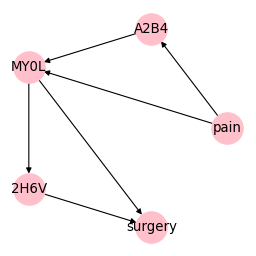

In [14]:
# View causal DAG (endogenous variables only).
u.plot_nx(df_0["DAG adjacency matrix"][0],
          labels = literal_eval(df_0["DAG nodes"][0]),
          figsize = (3,3), 
          dpi = 80)

### Associational level: Evaluate factual responses

In [15]:
# Perturb true responses to obtain synthetic predictions.
f_true = df_f_0["True"].to_numpy()
idx = np.random.choice(np.arange(len(f_true)), size = int(len(f_true)/10), replace = False)
f_pred = [f_true[i] if i not in idx else 1-f_true[i] for i in range(len(f_true))]
print(sum(np.where(f_pred != f_true, True, False)))

2000


In [16]:
# Treat responses for all effects as one long vector.
# A finer-grained analysis would compute metrics separately for each effect.
print("F1        =", f1_score(f_true, f_pred))
print("Precision =", precision_score(f_true, f_pred))
print("Recall    =", recall_score(f_true, f_pred))
print("Accuracy  =", accuracy_score(f_true, f_pred))

F1        = 0.9231537693076155
Precision = 0.9491940581542352
Recall    = 0.8985041136873597
Accuracy  = 0.9


### Interventional level: Evaluate interventional responses

In [17]:
# Intervention (cause = True).
do_1_true = df_cf_0["True (cause = True)"].to_numpy()
idx = np.random.choice(np.arange(len(do_1_true)), size = int(len(do_1_true)/10), replace = False)
do_1_pred = [do_1_true[i] if i not in idx else 1-do_1_true[i] for i in range(len(do_1_true))]
print(sum(np.where(do_1_pred != do_1_true, True, False)))

3000


In [18]:
# Treat responses for all cause-effect pairs as one long vector.
# A finer-grained analysis would compute metrics separately for each cause-effect pair.
print("F1        =", f1_score(do_1_true, do_1_pred))
print("Precision =", precision_score(do_1_true, do_1_pred))
print("Recall    =", recall_score(do_1_true, do_1_pred))
print("Accuracy  =", accuracy_score(do_1_true, do_1_pred))

F1        = 0.9251571699431195
Precision = 0.9511644608597517
Recall    = 0.9005342399222924
Accuracy  = 0.9


In [19]:
# Intervention (cause = False).
do_0_true = df_cf_0["True (cause = False)"].to_numpy()
idx = np.random.choice(np.arange(len(do_0_true)), size = int(len(do_0_true)/10), replace = False)
do_0_pred = [do_0_true[i] if i not in idx else 1-do_0_true[i] for i in range(len(do_0_true))]
print(sum(np.where(do_0_pred != do_0_true, True, False)))

3000


In [20]:
# Treat responses for all cause-effect pairs as one long vector.
# A finer-grained analysis would compute metrics separately for each cause-effect pair.
print("F1        =", f1_score(do_0_true, do_0_pred))
print("Precision =", precision_score(do_0_true, do_0_pred))
print("Recall    =", recall_score(do_0_true, do_0_pred))
print("Accuracy  =", accuracy_score(do_0_true, do_0_pred))

F1        = 0.8728166864507377
Precision = 0.8459894806048652
Recall    = 0.9014010507880911
Accuracy  = 0.9


### Counterfactual level: Evaluate PNS external validity and internal consistency

#### External validity of individual causal quantities

In [21]:
# Compute PNS estimates for each cause-effect pair.
# For illustration, we will demonstrate on (pain,surgery).
df_pred = pd.DataFrame({"Cause = True": do_1_pred, 
                        "Cause = False": do_0_pred})
pns_pred = u.get_pns_direct(df_pred,
                            y_do_x1 = "Cause = True", 
                            y_do_x0 = "Cause = False")
pns_true = pns_dict.get(0).get("('pain', 'surgery')")
external_validity_rae = u.get_rae(pns_true, pns_pred)

print("True PNS              =", pns_true)
print("Predicted PNS         =", pns_pred)
print("External validity RAE =", external_validity_rae)

True PNS              = 0.1345
Predicted PNS         = 0.30893333333333334
External validity RAE = 1.296902106567534


In [22]:
df_pred

,Cause = True,Cause = False
0,1,0
1,1,1
2,1,0
3,0,1
4,1,1
...,...,...
29995,1,0
29996,1,0
29997,1,1
29998,0,0


In [23]:
pns_dict.get(0)

{"('pain', 'surgery')": 0.1345,
 "('pain', 'MY0L')": 0.253,
 "('MY0L', 'surgery')": 0.5295,
 "[('pain', 'MY0L'), ('MY0L', 'surgery')]": 0.13396349999999999}

#### Internal consistency and external validity of compositions

In [24]:
%%capture
# Compute PNS for composition.
# We will perturb the true values to simulate LM responses with errors.
df_pain_VGJS = df_cf_0[df_cf_0["Cause-effect pair"] == "('pain', 'VGJS')"]
idx = np.random.choice(np.arange(len(df_pain_VGJS)), size = int(len(df_pain_VGJS)/10), replace = False)
true = df_pain_VGJS["True (cause = True)"].to_numpy()
df_pain_VGJS["Pred (cause = True)"] = [true[i] if i not in idx else 1-true[i] for i in range(len(true))]

idx = np.random.choice(np.arange(len(df_pain_VGJS)), size = int(len(df_pain_VGJS)/10), replace = False)
true = df_pain_VGJS["True (cause = False)"].to_numpy()
df_pain_VGJS["Pred (cause = False)"] = [true[i] if i not in idx else 1-true[i] for i in range(len(true))]

pns_pain_VGJS = u.get_pns_direct(df_pain_VGJS,
                                 y_do_x1 = "Pred (cause = True)", 
                                 y_do_x0 = "Pred (cause = False)")

df_VGJS_surgery = df_cf_0[df_cf_0["Cause-effect pair"] == "('VGJS', 'surgery')"]
idx = np.random.choice(np.arange(len(df_pain_VGJS)), size = int(len(df_pain_VGJS)/10), replace = False)
true = df_VGJS_surgery["True (cause = True)"].to_numpy()
df_VGJS_surgery["Pred (cause = True)"] = [true[i] if i not in idx else 1-true[i] for i in range(len(true))]

true = df_VGJS_surgery["True (cause = False)"].to_numpy()
idx = np.random.choice(np.arange(len(df_pain_VGJS)), size = int(len(df_pain_VGJS)/10), replace = False)
df_VGJS_surgery["Pred (cause = False)"] = [true[i] if i not in idx else 1-true[i] for i in range(len(true))]

pns_VGJS_surgery = u.get_pns_direct(df_VGJS_surgery,
                                    y_do_x1 = "Pred (cause = True)", 
                                    y_do_x0 = "Pred (cause = False)")

In [25]:
# Compute RAE for external validity.
comp_true = pns_dict.get(0).get("[('pain', 'VGJS'), ('VGJS', 'surgery')]")
comp_pred = pns_pain_VGJS*pns_VGJS_surgery
external_validity_rae = u.get_rae(comp_true, comp_pred)
print("External validity RAE =", external_validity_rae)

# Compare to a threshold for validity.
thresh = 0.1
print("Desired RAE threshold =", thresh)
print("RAE <= threshold:", external_validity_rae <= thresh)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'

In [ ]:
# Compute RAE for internal consistency.
internal_consistency_rae = u.get_rae(pns_pred, comp_pred)
print("Internal consistency RAE =", internal_consistency_rae)

# Compare to pre-defined threshold.
# We will use a multiplier on the threshold to be generous.
thresh = threshold_dict.get(0).get("[('pain', 'VGJS'), ('VGJS', 'surgery')]")
thresh *= 1.25
print("Desired RAE threshold =", thresh)
print("RAE <= threshold:", internal_consistency_rae <= thresh)

## Generate new tasks

In [ ]:
# Four BCCs of varying sizes and topology.
size = [3,4,4,2]
tg = ClinicalNotes(n_per_bcc = size, 
                   bcc_types = ["cycle", "wheel", "cycle", "cycle"])
context = tg.get_causal_context()
patient_history = tg.get_sample_context(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [ ]:
# See factual queries.
print()
print("- Factual queries:")
display(tg.get_factual_queries())

In [ ]:
# See counterfactual query pairs (interventional = True and intervention = False).
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Interventional queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

In [ ]:
print("- Interventional queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

In [ ]:
# Sample observational data from the structural causal model (SCM).
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

In [ ]:
# Sample interventional data from the structural causal model (SCM).
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())